In [1]:
#!pip install ydata-profiling demoji nltk scikit-learn gensim pyLDAvis textblob spacy textstat transformers torch xgboost shap

In [2]:
import requests, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk import bigrams, trigrams
from sklearn.feature_extraction.text import CountVectorizer
from textstat import flesch_reading_ease # exploring text complixity
# for sentiment analysis
from textblob import TextBlob
import spacy
# for clustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# feature importance of clustering 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import shap

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
#!python -m spacy download en_core_web_sm

In [3]:
new_df = pd.read_csv('../data/conversation_dataset.csv')

In [4]:
new_df

,category,conversation,word_count,A_bad_intent,B_bad_intent,description,topic
0,first participant in conversation is deceiving...,"A: Hey, I have something really important to t...",437,1.0,0.0,NaN,NaN
1,second participant in conversation is deceivin...,"A: Hey Sarah, I heard you recently went on a t...",368,0.0,1.0,NaN,NaN
2,both participants in conversation are deceivin...,"A: Hey, how have you been? It's been a while s...",400,1.0,1.0,NaN,NaN
3,none of participants in conversation try to de...,A: Hey Sarah! How was your weekend?\n\nB: Hi M...,494,0.0,0.0,NaN,NaN
4,first participant in conversation is deceiving...,A: Hey there! How are you doing today?\n\nB: H...,534,1.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...
195,none of participants in conversation try to de...,A: Hey there! I've been trying to perfect my r...,474,0.0,0.0,NaN,cooking tips or recipes
196,first participant in conversation is deceiving...,"A: Good morning, thank you for having me here ...",542,1.0,0.0,NaN,a job interview
197,second participant in conversation is deceivin...,A: Good afternoon! Thank you for taking the ti...,803,0.0,1.0,NaN,a job interview
198,both participants in conversation are deceivin...,"A: Good morning, and thank you for coming in t...",549,1.0,1.0,NaN,a job interview


In [6]:
def text_preprocess(message):
    processed = []   
    for text in message:
        # replaace URLs
        text = re.sub(r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)",'URL',text)  
        
        # Replace all non alphabets.
        #text = re.sub( "[^a-zA-Z0-9]", " ", text)  # this will replace emojies as well!
        
        # Remove HTML/XML tags (if any)
        text = re.sub(r'<.*?>', '', text)

        # Remove punctuation and symbols -- (not for now)
        # text = re.sub(r'[^\w\s]', '', text) 

        # Remove numbers -- not for now
        #text = re.sub(r'\d+', '', text)

        # Remove whitespaces (including new lines and tabs)
        text = text.strip().replace("\n", " ").replace("\r", " ").replace("\t", " ")
        
        processed.append(text)       
    return processed

new_df['conversation'] = text_preprocess(list(new_df['conversation']))

---

In [7]:
new_df['topic'].value_counts()

family wills and inheritances                    20
a job interview                                  16
sale or rental of property                       16
friends                                          12
cooking tips or recipes                           8
insurance claims after an accident                4
travel experiences                                4
discussing past relationships                     4
a diplomacy subject between european coutries     4
health issues                                     4
Name: topic, dtype: int64

In [16]:
def category_to_label(j):
    if j == 'first participant in conversation is deceiving the second one':
        return 0
    elif j == 'second participant in conversation is deceiving the first one':
        return 1
    elif j == 'both participants in conversation are deceiving each other':
        return 2
    elif j== 'none of participants in conversation try to deceive the other one':
        return 3      
           
new_df['labels'] = new_df.category.apply(category_to_label)
new_df[['category','labels']]

,category,labels
0,first participant in conversation is deceiving...,0
1,second participant in conversation is deceivin...,1
2,both participants in conversation are deceivin...,2
3,none of participants in conversation try to de...,3
4,first participant in conversation is deceiving...,0
...,...,...
195,none of participants in conversation try to de...,3
196,first participant in conversation is deceiving...,0
197,second participant in conversation is deceivin...,1
198,both participants in conversation are deceivin...,2


---
## Feature Extraction:

+ number of words in the sentence
+ frequency of functional words in the sentence
+ frequency of certain Parts-of-Speech (PoS) tags in the sentence such as:
+ + frequency of pronouns (total, first person, second person, third person)
+ + negations (e.g. use of "not"-type words)
+ + frequency of articles
+ + frequency of prepositions
+ frequency of certain N-grams in the sentence
+ sentence complexity.

+ frequency of words used found in some curated, potentially domain-specific dictionary
+ frequency of words of length > 6
+ sentiment
+ certainty (from self-doubting to absolutely certain)
+ implied causality
+ inclusivity/exclusivity
+ frequency of motion verbs
+ frequency of past tense verbs
+ frequency of future tense verbs
+ word/sentence embeddings (from e.g. bert-base encoder).

---
#### frequency of functional words in the sentence --> (stop words!?)

In [9]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def count_stop_words(sentence):
    words = sentence.split()
    stop_words_in_sentence = [word for word in words if word.lower() in stop_words]
    return len(stop_words_in_sentence)

new_df['stop_words_count'] = new_df['conversation'].apply(count_stop_words)
new_df[['conversation' , 'stop_words_count']]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\766619\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,conversation,stop_words_count
0,"A: Hey, I have something really important to t...",167
1,"A: Hey Sarah, I heard you recently went on a t...",128
2,"A: Hey, how have you been? It's been a while s...",166
3,A: Hey Sarah! How was your weekend? B: Hi Mar...,194
4,A: Hey there! How are you doing today? B: Hi!...,218
...,...,...
195,A: Hey there! I've been trying to perfect my r...,198
196,"A: Good morning, thank you for having me here ...",243
197,A: Good afternoon! Thank you for taking the ti...,365
198,"A: Good morning, and thank you for coming in t...",229


---
#### frequency of certain Parts-of-Speech (PoS) tags in the sentence

In [10]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

#Noun (NN)
#Verb (VB)
#Adjective(JJ)
#Adverb(RB)
#Preposition (IN)
#Conjunction (CC)
#Pronoun(PRP)
#Interjection (INT)

# here i get all pos!
# the result of this function would be json which wont be really useful as a feature
def pos_tag_frequency(sentence):
    words = word_tokenize(sentence)
    pos_tags = nltk.pos_tag(words)
    #select the second element in each tuple
    tags = [tag for word, tag in pos_tags if tag == 'PRP']
    tag_freq = Counter(tags)
    return tag_freq

#new_df['pos_tag_freq'] = new_df['processed_message'].apply(pos_tag_frequency)
#new_df[['processed_message' , 'pos_tag_freq']]

pron_freq = []
article_freq = []
prep_freq = []
adj_freq = []

for i, j in new_df.iterrows():       
    words = word_tokenize(j['conversation'])
    pos_tags = nltk.pos_tag(words)
    pron_freq.append(len([tag for word, tag in pos_tags if tag == 'PRP']))
    article_freq.append(sum([1 for word in words if word.lower() in ['the', 'a', 'an']]))
    prep_freq.append(len([tag for word, tag in pos_tags if tag == 'IN']))
    adj_freq.append(len([tag for word, tag in pos_tags if tag == 'JJ']))
        
new_df['pron_freq'] = pron_freq
new_df['article_freq'] = article_freq
new_df['prep_freq'] = prep_freq
new_df['adj_freq'] = adj_freq


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\766619\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\766619\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [11]:
new_df[['conversation' , 'pron_freq', 'article_freq', 'prep_freq', 'adj_freq']]

,conversation,pron_freq,article_freq,prep_freq,adj_freq
0,"A: Hey, I have something really important to t...",53,28,31,33
1,"A: Hey Sarah, I heard you recently went on a t...",32,34,18,23
2,"A: Hey, how have you been? It's been a while s...",47,23,27,42
3,A: Hey Sarah! How was your weekend? B: Hi Mar...,76,31,41,38
4,A: Hey there! How are you doing today? B: Hi!...,65,35,44,25
...,...,...,...,...,...
195,A: Hey there! I've been trying to perfect my r...,43,43,55,33
196,"A: Good morning, thank you for having me here ...",60,48,57,44
197,A: Good afternoon! Thank you for taking the ti...,78,67,93,61
198,"A: Good morning, and thank you for coming in t...",59,39,70,44


---
#### frequency of certain N-grams in the sentence

In [23]:
# should actually check how many of top n-grams each sentenc contains?

In [12]:
#identify the top N n-grams from text
def get_top_ngram(corpus, n=None, m=20):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]       
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:m]

In [13]:
top_n_bigrams=get_top_ngram(new_df['conversation'],2)
top_n_bigrams

[('ve been', 337),
 ('in the', 325),
 ('of the', 293),
 ('about the', 238),
 ('we re', 225),
 ('for the', 213),
 ('they re', 200),
 ('you know', 188),
 ('you re', 182),
 ('with the', 182),
 ('that sounds', 174),
 ('to be', 172),
 ('do you', 170),
 ('have you', 164),
 ('on the', 154),
 ('it was', 153),
 ('to the', 146),
 ('we can', 141),
 ('and the', 139),
 ('want to', 138)]

In [14]:
top_n_trigrams=get_top_ngram(new_df['conversation'],3)
top_n_trigrams

[('looking forward to', 71),
 ('thank you for', 60),
 ('what kind of', 57),
 ('have you been', 57),
 ('you tell me', 57),
 ('that sounds like', 53),
 ('do you have', 53),
 ('how about you', 52),
 ('do you think', 52),
 ('ve been thinking', 51),
 ('it all about', 50),
 ('that would be', 50),
 ('you have any', 49),
 ('one of the', 40),
 ('to make sure', 37),
 ('could you tell', 35),
 ('more about the', 35),
 ('how have you', 34),
 ('tell me more', 33),
 ('me more about', 33)]

In [18]:
# check if the sentence includes top bigrams or trigrams:
top_bigrams = [i[0] for i in top_n_bigrams]
top_trigrams =  [i[0] for i in top_n_trigrams]

def count_ngrams(sentence, n):
    words = word_tokenize(sentence)
    separator = ' '
    if n == 2:
        n_grams = sum([1 if separator.join(i) in top_bigrams else 0 for i in list(bigrams(words))])
    elif n == 3:
        n_grams = sum([1 if separator.join(i) in top_trigrams else 0 for i in list(trigrams(words))])
    else:
        return 0
    return n_grams

new_df['top_bigram_freq'] = new_df['conversation'].apply(lambda x: count_ngrams(x, 2))
new_df['top_trigram_freq'] = new_df['conversation'].apply(lambda x: count_ngrams(x, 3))

In [19]:
new_df[['conversation' , 'top_bigram_freq' , 'top_trigram_freq', 'labels']]

,conversation,top_bigram_freq,top_trigram_freq,labels
0,"A: Hey, I have something really important to t...",2,0,0
1,"A: Hey Sarah, I heard you recently went on a t...",6,1,1
2,"A: Hey, how have you been? It's been a while s...",9,4,2
3,A: Hey Sarah! How was your weekend? B: Hi Mar...,5,2,3
4,A: Hey there! How are you doing today? B: Hi!...,4,1,0
...,...,...,...,...
195,A: Hey there! I've been trying to perfect my r...,6,0,3
196,"A: Good morning, thank you for having me here ...",5,4,0
197,A: Good afternoon! Thank you for taking the ti...,12,5,1
198,"A: Good morning, and thank you for coming in t...",5,4,2


In [20]:
new_df[new_df['top_trigram_freq'] > 0]

,category,conversation,word_count,A_bad_intent,B_bad_intent,description,topic,num_words_sentence,stop_words_count,pron_freq,article_freq,prep_freq,adj_freq,labels,top_bigram_freq,top_trigram_freq
1,second participant in conversation is deceivin...,"A: Hey Sarah, I heard you recently went on a t...",368,0.0,1.0,NaN,NaN,289,128,32,34,18,23,1,6,1
2,both participants in conversation are deceivin...,"A: Hey, how have you been? It's been a while s...",400,1.0,1.0,NaN,NaN,369,166,47,23,27,42,2,9,4
3,none of participants in conversation try to de...,A: Hey Sarah! How was your weekend? B: Hi Mar...,494,0.0,0.0,NaN,NaN,465,194,76,31,41,38,3,5,2
4,first participant in conversation is deceiving...,A: Hey there! How are you doing today? B: Hi!...,534,1.0,0.0,NaN,NaN,504,218,65,35,44,25,0,4,1
5,second participant in conversation is deceivin...,"A: Hey, I heard you recently started investing...",507,0.0,1.0,NaN,NaN,457,190,39,46,37,39,1,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,none of participants in conversation try to de...,"A: Hey, I've been feeling really tired lately ...",413,0.0,0.0,NaN,health issues,389,171,43,25,32,26,3,3,1
196,first participant in conversation is deceiving...,"A: Good morning, thank you for having me here ...",542,1.0,0.0,NaN,a job interview,541,243,60,48,57,44,0,5,4
197,second participant in conversation is deceivin...,A: Good afternoon! Thank you for taking the ti...,803,0.0,1.0,NaN,a job interview,794,365,78,67,93,61,1,12,5
198,both participants in conversation are deceivin...,"A: Good morning, and thank you for coming in t...",549,1.0,1.0,NaN,a job interview,540,229,59,39,70,44,2,5,4


---
#### sentence complexity

In [22]:
# flesch_reading_ease => 206.835 - 1.015 * (total_words / total_sentences) - 84.6 * (total_syllables / total_words)
new_df['text_ease'] = new_df['conversation'].apply(lambda x : flesch_reading_ease(x))
new_df[new_df['text_ease']== new_df['text_ease'].max()]

,category,conversation,word_count,A_bad_intent,B_bad_intent,description,topic,num_words_sentence,stop_words_count,pron_freq,article_freq,prep_freq,adj_freq,labels,top_bigram_freq,top_trigram_freq,text_ease
81,second participant in conversation is deceivin...,"A: Hey, did you hear about that new restaurant...",573,0.0,1.0,NaN,NaN,561,225,77,48,39,39,1,16,0,98.01


linguistic complexity is a broad field and there are many other factors could be considered, like the use of passive voice, nominalizations, advanced punctuation, lexical density, and so on.

In [31]:
#frequency of words used found in some curated, potentially domain-specific dictionary
# This is challenging, which domain should be explored??
# wordnet from nltk.corpus might be useful if know which domain we are exploring!

In [24]:
#frequency of words of length > 6
#get the number of words longer than 6 in each message
new_df['num_long_words'] = new_df['conversation'].str.split().apply(lambda x : [1 if len(i) > 6 else 0 for i in x]).map(lambda x: sum(x))
new_df[['conversation' , 'num_long_words']]

,conversation,num_long_words
0,"A: Hey, I have something really important to t...",74
1,"A: Hey Sarah, I heard you recently went on a t...",62
2,"A: Hey, how have you been? It's been a while s...",75
3,A: Hey Sarah! How was your weekend? B: Hi Mar...,83
4,A: Hey there! How are you doing today? B: Hi!...,118
...,...,...
195,A: Hey there! I've been trying to perfect my r...,80
196,"A: Good morning, thank you for having me here ...",159
197,A: Good afternoon! Thank you for taking the ti...,208
198,"A: Good morning, and thank you for coming in t...",124


In [26]:
#sentiment
# textblob is more sensitive to negative sentiments than nltk
new_df['sentiment'] = new_df['conversation'].apply(lambda x: TextBlob(x).sentiment.polarity)  
new_df[['conversation' , 'sentiment']]

,conversation,sentiment
0,"A: Hey, I have something really important to t...",0.249578
1,"A: Hey Sarah, I heard you recently went on a t...",0.310256
2,"A: Hey, how have you been? It's been a while s...",0.225360
3,A: Hey Sarah! How was your weekend? B: Hi Mar...,0.383349
4,A: Hey there! How are you doing today? B: Hi!...,0.157158
...,...,...
195,A: Hey there! I've been trying to perfect my r...,0.107930
196,"A: Good morning, thank you for having me here ...",0.238281
197,A: Good afternoon! Thank you for taking the ti...,0.259081
198,"A: Good morning, and thank you for coming in t...",0.308690


---
#### certainty (from self-doubting to absolutely certain)

This one cannot be implemented simply using nlp tools like nltk or by ML models eaither fine-tunned pre-traiined ones or those traind on a labled dataset.

---
#### implied causality

---
#### inclusivity/exclusivity

---
#### frequency of motion verbs

In [28]:
# get the list of all verbs in the dataset
nlp = spacy.load("en_core_web_sm")
def get_unique_verbs(texts):
    unique_verbs = set()  #  set to store unique verbs
    for text in texts:
        doc = nlp(text)
        # add the lemmatized form of the word to the set if it is a verb.
        unique_verbs.update(token.lemma_ for token in doc if token.pos_ == "VERB")
    return unique_verbs

verbs = list(get_unique_verbs(new_df['conversation']))

In [29]:
print(verbs)

['knock', 'successful', 'transfer', 'mash', 'pun', 'inform', 'brush', 'function', 'guide', 'deceive', 'fake', 'know', 'hope', 'charge', 'relate', 'credit', 'interest', 'verse', 'crunch', 'process', 'claim', 'strike', 'shift', 'eliminate', 'import', 'understand', 'safeguard', 'snack', 'downsize', 'compost', 'contribute', 'prove', 'protect', 'roam', 'forward', 'bend', 'loop', 'canoe', 'estimate', 'treat', 'boil', 'rid', 'embrace', 'photograph', 'mark', 'begin', 'reflect', 'lounge', 'regret', 'sprinkle', 'suppress', 'fulfil', 'ignore', 'dance', 'capture', 'limit', 'debunk', 'mellifie', 'depend', 'realize', 'pressure', 'exhibit', 'file', 'tour', 'say', 'preserve', 'plug', 'award', 'measure', 'gather', 'change', 'regulate', 'am', 'drive', 'lend', 'situation', 'taste', 'overextend', 'paint', 'elevate', 'live', 'fly', 'dig', 'circulate', 'identify', 'ask', 'comfort', 'shatter', 'surround', 'shop', 'quit', 'dedicate', 'invest', 'share', 'resonate', 'explain', 'branch', 'interpret', 'adjust', '

In [30]:
# extract motion verbs from the list of all verbs using Chat-Gpt
motion_verbs = ['pitch', 'run', 'shudder', 'chase', 'track', 'arise', 'shrink', 'ride', 'roll', 'fly', 'bounce', 'mow', 'cut',
                'regroup', 'chill', 'overrun', 'descend', 'explode', 'switch', 'hug', 'eat', 'jiggle', 'dance', 'park', 'sit', 
                'seek', 'return', 'gallivant', 'transit', 'dive', 'pop', 'bump', 'send', 'steal', 'wash', 'walk', 'swing', 
                'float', 'squeeze', 'scroll', 'stick', 'poke', 'catch', 'evacuate', 'melt', 'raise', 'board', 'pour', 'move', 
                'scramble', 'hang', 'trigger', 'fling', 'crash', 'start', 'dry', 'answer', 'stall', 'peel', 'capture', 'run', 
                'box', 'end', 'look', 'try', 'hover', 'jump', 'acquire', 'tie', 'dip', 'recover', 'explore', 'fish', 'hop',
                'take', 'execute', 'rob', 'launch', 'arrive', 'collect', 'harm', 'do', 'hand', 'gather', 'give', 'split', 
                'trip', 'close', 'part', 'snap', 'bury', 'rush', 'greet', 'weigh', 'swing', 'pay', 'enter', 'put', 'separate',
                'unite', 'fix', 'wrap', 'skate', 'tell', 'lead', 'rescue', 'eject', 'perceive', 'rum', 'loosen', 'welcome',
                'break', 'tread', 'speak', 'freak', 'protect', 'impose', 'explain', 'attend', 'prepare', 'tend', 'upgrade', 
                'advance', 'sneak', 'kick', 'consume', 'continue', 'train', 'drag', 'hint', 'barge', 'volunteer', 'swoop',
                'rotate', 'head', 'live', 'match', 'exit', 'ward', 'string', 'tease', 'side', 'offer', 'pull', 'turn', 'shut', 
                'laugh', 'extract', 'click', 'overcome', 'race', 'grill', 'lay', 'declare', 'ski', 'face', 'snag', 'deceive',
                'survive', 'design', 'spin', 'build', 'discard', 'slam', 'reconsider', 'have', 'pin', 'realize', 'foreclose', 
                'emerge', 'provide', 'picture', 'ascertain', 'pass', 'work', 'cascade', 'emerge', 'contact', 'alter', 'receive',
                'dig', 'interpret', 'mop', 'spread', 'need', 'plan', 'smell', 'hit', 'object', 'block', 'pretend', 'empty', 
                'blow', 'bind', 'stab', 'reason', 'watch', 'standby', 'crave', 'verify', 'corner', "approach","arrive","ascend",
                "backpedal","balance","bounce","climb","crawl","creep","dance","descend","dodge","drag","drift","drive","fall",
                "float","fly","gallop","glide","hop","jump","kick","leap","march","move","paddle","pedal","pull","push","run",
                "sail","scoot","skate","slide","spin","split","sprint","stand","stop","stroll","swim","swing","trot","walk",
                "waltz","wiggle","zoom",]

In [31]:
nlp = spacy.load("en_core_web_sm")
def count_motion_verbs(text):
    doc = nlp(text)
    # count motion verbs
    count = sum(1 for token in doc if token.pos_ == "VERB" and token.lemma_ in motion_verbs)
    return count

new_df['motion_verb_count'] = new_df['conversation'].apply(count_motion_verbs)

In [32]:
new_df[['conversation', 'motion_verb_count']]

,conversation,motion_verb_count
0,"A: Hey, I have something really important to t...",19
1,"A: Hey Sarah, I heard you recently went on a t...",10
2,"A: Hey, how have you been? It's been a while s...",15
3,A: Hey Sarah! How was your weekend? B: Hi Mar...,27
4,A: Hey there! How are you doing today? B: Hi!...,21
...,...,...
195,A: Hey there! I've been trying to perfect my r...,10
196,"A: Good morning, thank you for having me here ...",22
197,A: Good afternoon! Thank you for taking the ti...,39
198,"A: Good morning, and thank you for coming in t...",26


---
#### frequency of past tense verbs

In [33]:
nltk.download('averaged_perceptron_tagger')
def get_past_tense_verbs(text):
    word_tokens = word_tokenize(text)
    tagged = nltk.pos_tag(word_tokens)
    past_tense_verbs = [word for word, pos in tagged if pos == 'VBD']
    return len(past_tense_verbs)

new_df['num_past_tense'] = new_df['conversation'].apply(get_past_tense_verbs)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\766619\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [34]:
new_df[['conversation', 'num_past_tense']]

,conversation,num_past_tense
0,"A: Hey, I have something really important to t...",3
1,"A: Hey Sarah, I heard you recently went on a t...",18
2,"A: Hey, how have you been? It's been a while s...",4
3,A: Hey Sarah! How was your weekend? B: Hi Mar...,22
4,A: Hey there! How are you doing today? B: Hi!...,5
...,...,...
195,A: Hey there! I've been trying to perfect my r...,1
196,"A: Good morning, thank you for having me here ...",31
197,A: Good afternoon! Thank you for taking the ti...,25
198,"A: Good morning, and thank you for coming in t...",2


---
#### frequency of future tense verbs

In [35]:
# Load the English language model
nlp = spacy.load('en_core_web_sm')

In [36]:
def get_future_tense_verbs(text):
    doc = nlp(text)
    future_tense_verbs = []
    for token in doc:
        # check if the token is not the first or the last in the doc
        if token.i > 0 and token.i < len(doc) - 1:
            # handling the case for "will" and "shall"
            if token.lower_ in ["will", "shall"]:
                next_token = token.nbor()  # The token after "will" or "shall"
                if next_token.pos_ == "VERB":
                    future_tense_verbs.append(next_token.text)
            # handling the case for "is going to" --------------- should also handle "are going to" ------------
            elif token.lower_ == "going" and token.nbor(-1).lower_ == "is" and token.nbor(1).lower_ == "to":
                next_token = token.nbor(1)  # the token after "going", expected "to"
                next_next_token = next_token.nbor()  # the token after "to"
                if next_next_token.pos_ == "VERB":
                    future_tense_verbs.append(next_next_token.text)
    # for the case where "will" or "shall" is the last word in a sentence
    for sent in doc.sents:
        last_word = sent[-1]
        if last_word.lower_ in ["will", "shall"]:
            # handle cases or add context-specific actions
            pass  # or add to list if contextually correct in sentences like "Tomorrow, I will."
    return len(future_tense_verbs)
 

new_df['num_future_tense'] = new_df['conversation'].apply(get_future_tense_verbs)

In [37]:
new_df[['conversation', 'num_future_tense']]

,conversation,num_future_tense
0,"A: Hey, I have something really important to t...",0
1,"A: Hey Sarah, I heard you recently went on a t...",0
2,"A: Hey, how have you been? It's been a while s...",2
3,A: Hey Sarah! How was your weekend? B: Hi Mar...,0
4,A: Hey there! How are you doing today? B: Hi!...,2
...,...,...
195,A: Hey there! I've been trying to perfect my r...,1
196,"A: Good morning, thank you for having me here ...",0
197,A: Good afternoon! Thank you for taking the ti...,0
198,"A: Good morning, and thank you for coming in t...",0


In [38]:
new_df[new_df['num_future_tense'] > 0]

,category,conversation,word_count,A_bad_intent,B_bad_intent,description,topic,num_words_sentence,stop_words_count,pron_freq,...,adj_freq,labels,top_bigram_freq,top_trigram_freq,text_ease,num_long_words,sentiment,motion_verb_count,num_past_tense,num_future_tense
2,both participants in conversation are deceivin...,"A: Hey, how have you been? It's been a while s...",400,1.0,1.0,NaN,NaN,369,166,47,...,42,2,9,4,88.13,75,0.225360,15,4,2
4,first participant in conversation is deceiving...,A: Hey there! How are you doing today? B: Hi!...,534,1.0,0.0,NaN,NaN,504,218,65,...,25,0,4,1,79.77,118,0.157158,21,5,2
5,second participant in conversation is deceivin...,"A: Hey, I heard you recently started investing...",507,0.0,1.0,NaN,NaN,457,190,39,...,39,1,9,1,69.38,125,0.154050,17,3,1
9,second participant in conversation is deceivin...,"A: Hey, I've been trying to reach you for a co...",533,0.0,1.0,NaN,NaN,471,214,62,...,23,1,12,0,88.33,75,0.205665,23,13,1
12,first participant in conversation is deceiving...,"A: Hey, I hope you're doing well. I wanted to ...",628,1.0,0.0,NaN,NaN,552,260,80,...,46,0,7,1,77.43,122,0.220951,26,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,first participant in conversation is deceiving...,A: Hey there! I saw your ad about looking for ...,476,1.0,0.0,NaN,sale or rental of property,459,207,66,...,23,0,7,4,94.96,64,0.328460,16,2,1
185,second participant in conversation is deceivin...,A: Hello! I saw your listing for the house ren...,550,0.0,1.0,NaN,sale or rental of property,491,225,64,...,29,1,14,7,78.85,104,0.326656,15,1,1
192,first participant in conversation is deceiving...,"A: Hey, I heard you're trying to improve your ...",469,1.0,0.0,Note: Many of the tips provided by participant...,cooking tips or recipes,344,131,34,...,16,0,5,0,87.62,65,0.126847,11,6,1
193,second participant in conversation is deceivin...,A: Hey! I'm trying to make a lasagna for the f...,349,0.0,1.0,NaN,cooking tips or recipes,329,138,33,...,28,1,12,0,96.99,40,0.283533,11,4,2


---
#### Correaltion Matrix


<Axes: >

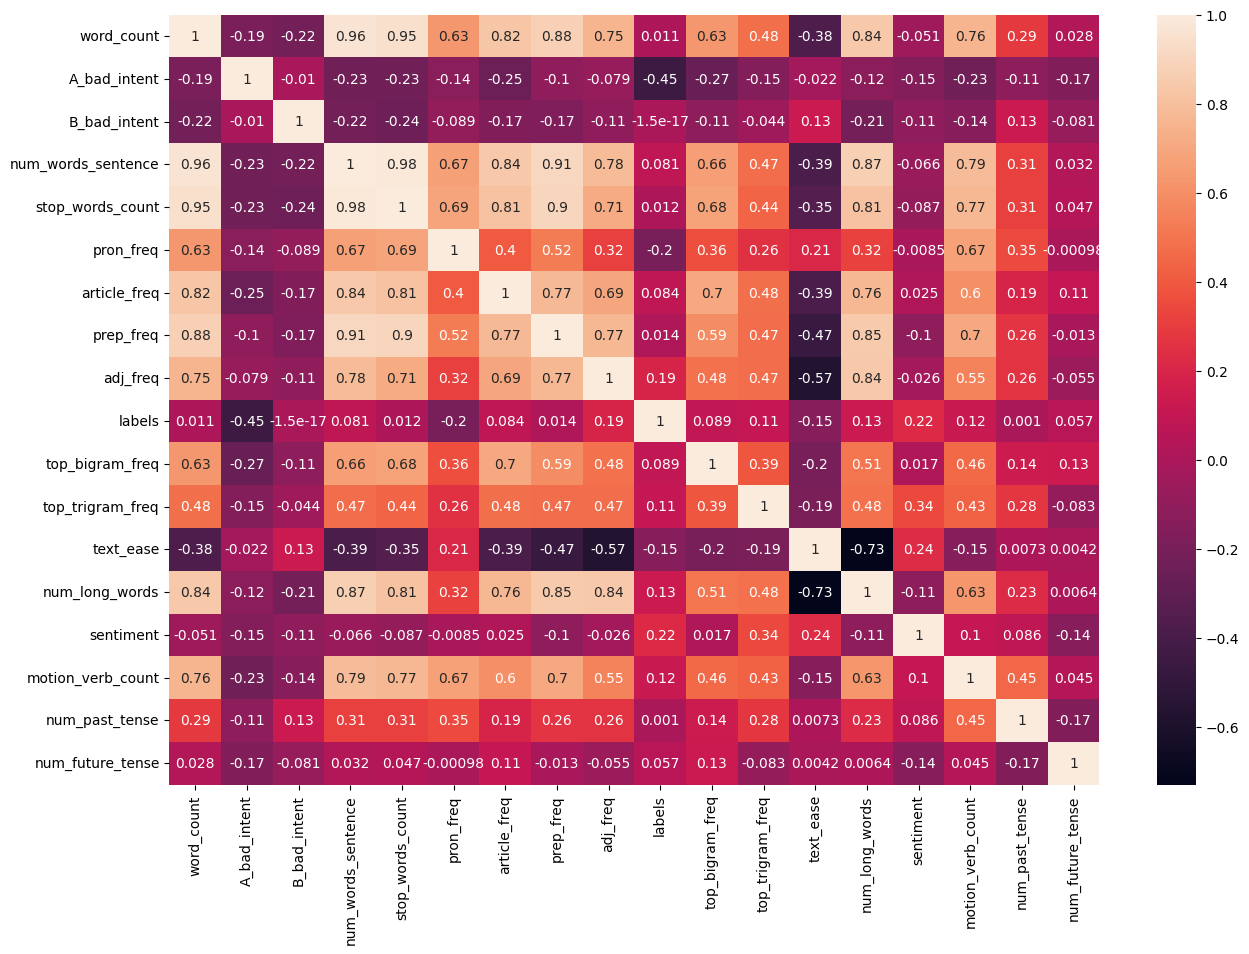

In [39]:
plt.figure(figsize=(15,10))
sns.heatmap(new_df.corr(),  annot=True)

---
#### save the proceesed dataframe into a file

In [49]:
#new_df.to_json('data/processed_all.jsonl', orient='records', lines=True)

---
### Clustering

In [50]:
#new_df = pd.read_json('data/processed_all.jsonl', lines=True)
#new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17289 entries, 0 to 17288
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   game_id             17289 non-null  int64  
 1   sender              17289 non-null  object 
 2   receiver            17289 non-null  object 
 3   message             17289 non-null  object 
 4   sender_label        17289 non-null  bool   
 5   receiver_label      17289 non-null  object 
 6   score               17289 non-null  int64  
 7   delta_score         17289 non-null  int64  
 8   final_delta_score   17289 non-null  int64  
 9   processed_message   17289 non-null  object 
 10  num_words_sentence  17289 non-null  int64  
 11  stop_words_count    17289 non-null  int64  
 12  pron_freq           17289 non-null  int64  
 13  article_freq        17289 non-null  int64  
 14  prep_freq           17289 non-null  int64  
 15  adj_freq            17289 non-null  int64  
 16  top_

In [40]:
clu_df = new_df.drop(['labels'], axis = 1)
clu_df = clu_df.select_dtypes(include='number')

In [41]:
clu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   word_count          200 non-null    int64  
 1   A_bad_intent        200 non-null    float64
 2   B_bad_intent        200 non-null    float64
 3   num_words_sentence  200 non-null    int64  
 4   stop_words_count    200 non-null    int64  
 5   pron_freq           200 non-null    int64  
 6   article_freq        200 non-null    int64  
 7   prep_freq           200 non-null    int64  
 8   adj_freq            200 non-null    int64  
 9   top_bigram_freq     200 non-null    int64  
 10  top_trigram_freq    200 non-null    int64  
 11  text_ease           200 non-null    float64
 12  num_long_words      200 non-null    int64  
 13  sentiment           200 non-null    float64
 14  motion_verb_count   200 non-null    int64  
 15  num_past_tense      200 non-null    int64  
 16  num_futu

---
#### To find the feature importance after clustering

In [42]:
def dtree_get_feature_importance(x,y):
    
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)
    model = DecisionTreeClassifier(random_state=0)
    model.fit(X_train, y_train)

    #evaluate the model's accuracy to see how it performs
    predictions = model.predict(X_test)
    if(hasattr(x, 'columns')):
        print(np.array(y_test))
        print(predictions)
        accuracy = accuracy_score(y_test, predictions)
        print(f"Accuracy: {accuracy * 100:.2f}%")

        # get feature importances
        feature_importances = model.feature_importances_
         # importances as a more interpretable series:
         # feature_names : if x is a df is columns if its a reduced from pca is pca components
        importance_series = pd.Series(feature_importances, index=x.columns)
        # sort the features by importance
        sorted_importances = importance_series.sort_values(ascending=False)
        print(sorted_importances)
    print()
    print('SHAP')
    # apply SHAP
    explainer = shap.Explainer(model)
    shap_values = explainer(X_test)[:, :, 1] 
    # visualize the first prediction's explanation
    shap.plots.waterfall(shap_values[0]) 
    #shap.plots.waterfall(shap_values[0, 0])
    # summarize the effects of all the features
    shap.summary_plot(shap_values, X_test)
   

#### KMeans

In [43]:
def dimentionality_reduction_report(df, components):       
    for i, component in enumerate(components):
        component_with_feature = zip(df.columns.to_list(), component)
        # Sort the features based on the absolute value of component coefficients
        most_important = sorted(component_with_feature, key=lambda x: np.abs(x[1]), reverse=True)
        print(f"Most important features for component {i + 1}:")
        for feature, value in most_important[:3]:  # print top 3; change the number here for more features
            print(f"{feature}: {value}")
        print()


In [44]:
# code from : https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html
from collections import defaultdict
from time import time

from sklearn import metrics

evaluations = []
evaluations_std = []


def fit_and_evaluate(km, X, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)
    

#### cluster only numerical features:

In [45]:
clu_df.isna().any()

word_count            False
A_bad_intent          False
B_bad_intent          False
num_words_sentence    False
stop_words_count      False
pron_freq             False
article_freq          False
prep_freq             False
adj_freq              False
top_bigram_freq       False
top_trigram_freq      False
text_ease             False
num_long_words        False
sentiment             False
motion_verb_count     False
num_past_tense        False
num_future_tense      False
dtype: bool

In [46]:
#dimmensionality reduction
#a PCA-like dimmensionality reduction that works on sparse data
svd_n_components=5
svd = TruncatedSVD(n_components=svd_n_components, random_state=42)
x_svd = svd.fit_transform(clu_df) 
dimentionality_reduction_report(clu_df, svd.components_)

Most important features for component 1:
word_count: 0.6774089175133382
num_words_sentence: 0.6465761990040255
stop_words_count: 0.28373281090469527

Most important features for component 2:
num_long_words: 0.6242713880204399
text_ease: -0.544304635032222
word_count: -0.3886128631841142

Most important features for component 3:
word_count: -0.5758806938911535
num_words_sentence: 0.47123890282778513
num_long_words: -0.40955742363214126

Most important features for component 4:
text_ease: 0.6553848357956108
stop_words_count: -0.47057928465712945
num_long_words: 0.3297542304694481

Most important features for component 5:
pron_freq: -0.6955744442598706
stop_words_count: 0.3949366765941614
article_freq: 0.3709784791253801



In [47]:
# normalise the data
scaler = StandardScaler() 
df_normalized = scaler.fit_transform(x_svd)

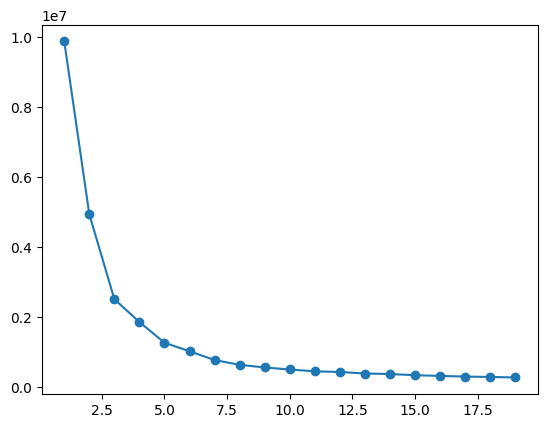

In [48]:
#determine the number of clusters -- elbow method
inertia = []
for i in range(1, 20):
    km = KMeans(n_clusters = i)
    km.fit(x_svd)
    #km.fit(clu_df)
    inertia.append(km.inertia_)
    
plt.plot(range(1, 20), inertia, marker='o' )

In [49]:
true_k = 4
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=300, n_init=1)
clusters = model.fit_predict(x_svd)
#clusters = model.fit_predict(df_clu)
#fit_and_evaluate(kmeans, X_tfidf, name="KMeans\non tf-idf vectors")
new_df['Kmeans_cluster'] = clusters
new_df[['num_long_words', 'Kmeans_cluster']]

,num_long_words,Kmeans_cluster
0,74,1
1,62,1
2,75,1
3,83,1
4,118,2
...,...,...
195,80,1
196,159,2
197,208,0
198,124,2


[0 0 0 2 0 3 0 2 1 2 1 0 0 1 2 2 2 3 1 3 0 0 0 0 2 1 2 2 0 0 2 0 1 2 0 2 0
 0 0 0]
[0 2 0 2 0 3 0 2 1 2 1 2 0 1 2 2 2 3 1 3 2 0 0 0 2 1 2 2 0 0 1 0 1 2 0 2 0
 0 0 0]
Accuracy: 90.00%
num_words_sentence    0.929293
word_count            0.070707
top_bigram_freq       0.000000
num_past_tense        0.000000
motion_verb_count     0.000000
sentiment             0.000000
num_long_words        0.000000
text_ease             0.000000
top_trigram_freq      0.000000
adj_freq              0.000000
A_bad_intent          0.000000
prep_freq             0.000000
article_freq          0.000000
pron_freq             0.000000
stop_words_count      0.000000
B_bad_intent          0.000000
num_future_tense      0.000000
dtype: float64

SHAP


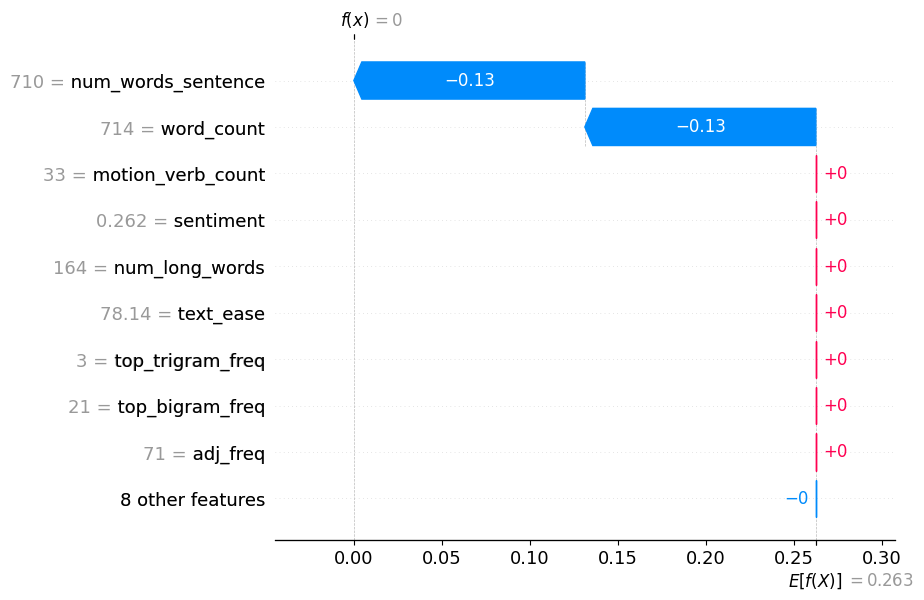

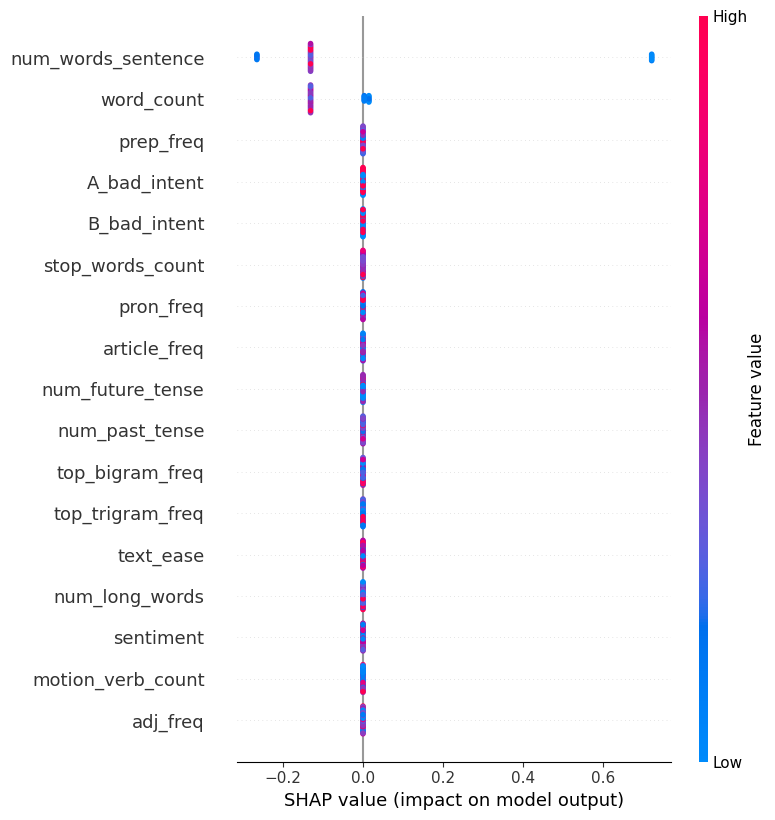

In [51]:
X = clu_df
y = new_df['Kmeans_cluster']  # target variable

#X = clu_df.drop(['labels'], axis=1)
#y = clu_df['labels'] # target variable

dtree_get_feature_importance(X, y)

<Axes: xlabel='Kmeans_cluster', ylabel='text_ease'>

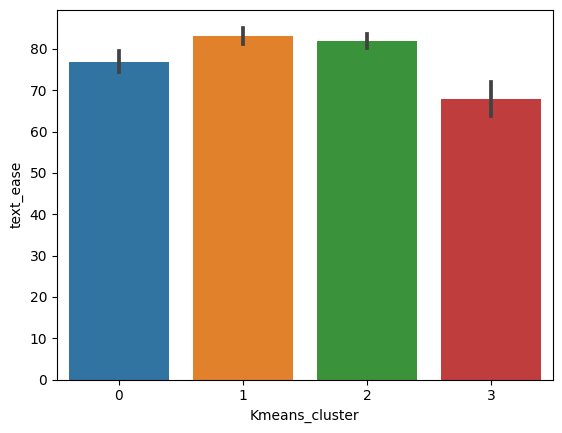

In [52]:
sns.barplot(x= new_df['Kmeans_cluster'], y = new_df['text_ease'])

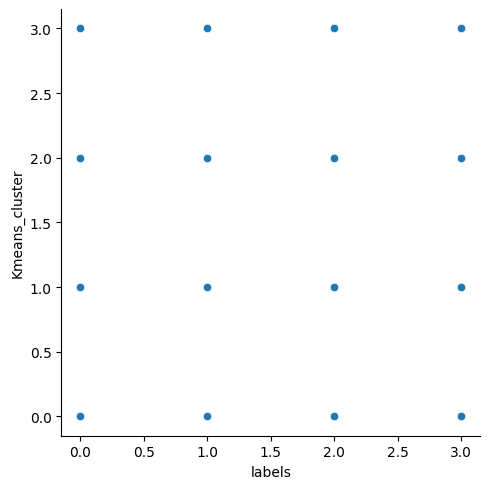

In [55]:
sns.relplot(y= new_df['Kmeans_cluster'], x = new_df['labels'])

In [56]:
# Internal eval: silhouette -> how similar an object is to its own cluster compared to other clusters
# higher the better(-1 to 1)
silhouette_avg = silhouette_score(x_svd, model.labels_)
print(f"Silhouette Score: {silhouette_avg}")
# Internal eval: Davies-Bouldin -> average similarity between clusters, that compares the distance between clusters with the size of the clusters
# lower score is better(0 to 1)
davies_score = davies_bouldin_score(x_svd, model.labels_)
print("Davies-Bouldin index:", davies_score)

Silhouette Score: 0.41878471219004626
Davies-Bouldin index: 0.6969854089016285


#### Cluster using vectorization of clusters as well

In [58]:
#vectorize the text

vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(new_df['conversation'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

clu_df = pd.concat([clu_df, tfidf_df], axis=1)

feature_names = vectorizer.get_feature_names_out() 
#feature_names


In [59]:
clu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Columns: 5479 entries, word_count to zoned
dtypes: float64(5466), int64(13)
memory usage: 8.4 MB


In [60]:
#dimmensionality reduction
#a PCA-like dimmensionality reduction that works on sparse data
svd = TruncatedSVD(n_components=5, random_state=42)
x_svd = svd.fit_transform(clu_df) 
dimentionality_reduction_report(clu_df, svd.components_)       

Most important features for component 1:
word_count: 0.6774088792149913
num_words_sentence: 0.6465761621588092
stop_words_count: 0.28373279466028173

Most important features for component 2:
num_long_words: 0.6242697022046859
text_ease: -0.5443025937237244
word_count: -0.38860536104354654

Most important features for component 3:
word_count: -0.5758819581627782
num_words_sentence: 0.47123916913762876
num_long_words: -0.4095479276080007

Most important features for component 4:
text_ease: 0.6553666688761899
stop_words_count: -0.4705745680961147
num_long_words: 0.32974806040093624

Most important features for component 5:
pron_freq: -0.6955448376457478
stop_words_count: 0.3948890566292022
article_freq: 0.3709738925988831



In [61]:
# normalise the data
scaler = StandardScaler() 
df_normalized = scaler.fit_transform(clu_df)

In [63]:
true_k = 6
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
labels = new_df['labels']
fit_and_evaluate(model, x_svd, name="KMeans tf-idf vectors")

#clusters = model.fit_predict(clu_df)
#new_df['Kmeans_cluster'] = clusters
#new_df[['num_long_words', 'Kmeans_cluster']]

clustering done in 0.01 ± 0.00 s 
Homogeneity: 0.062 ± 0.009
Completeness: 0.060 ± 0.009
V-measure: 0.061 ± 0.009
Adjusted Rand-Index: 0.035 ± 0.006
Silhouette Coefficient: 0.409 ± 0.021


In [64]:
clu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Columns: 5479 entries, word_count to zoned
dtypes: float64(5466), int64(13)
memory usage: 8.4 MB



SHAP


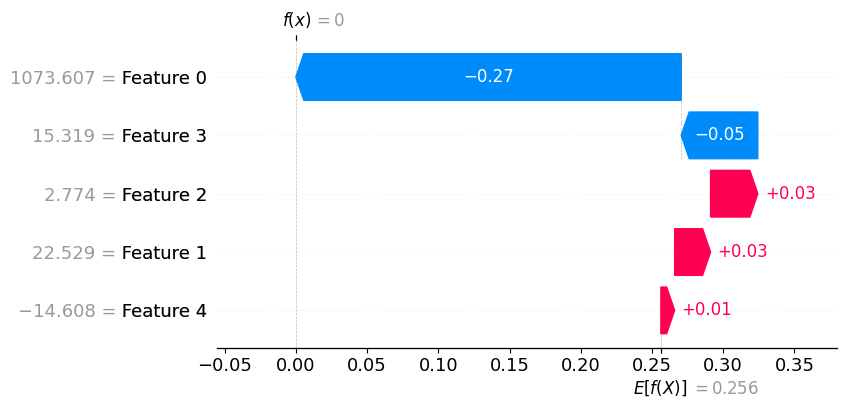

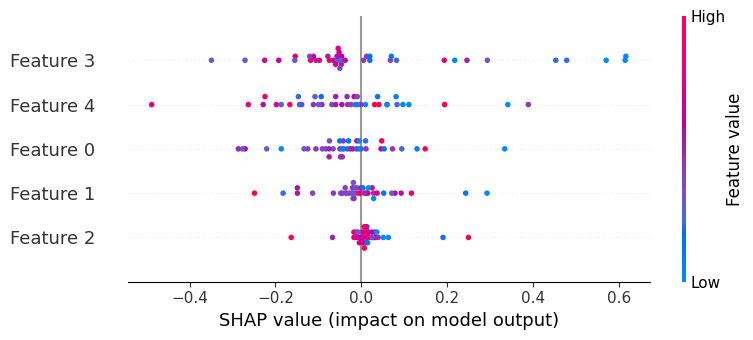

In [65]:
X = x_svd
y = new_df['labels']  # target variable
dtree_get_feature_importance(X, y)

Those Features are svd components

In [66]:
# Internal eval: silhouette -> how similar an object is to its own cluster compared to other clusters
# higher the better(-1 to 1)
silhouette_avg = silhouette_score(x_svd, model.labels_)
print(f"Silhouette Score: {silhouette_avg}")
# Internal eval: Davies-Bouldin -> average similarity between clusters, that compares the distance between clusters with the size of the clusters
# lower score is better(0 to 1)
davies_score = davies_bouldin_score(x_svd, model.labels_)
print("Davies-Bouldin index:", davies_score)

Silhouette Score: 0.4092309806473344
Davies-Bouldin index: 0.6274568340499345


In [76]:
#plots

---
#### DBSCAN